In [13]:
# Data Processing
import numpy as np
import pandas as pd

# Basic Visualization tools
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_palette('husl')


# Bokeh (interactive visualization)
import bokeh
from bokeh.io import show, output_notebook
from bokeh.palettes import Spectral9
from bokeh.plotting import figure
output_notebook() # You can use output_file()

# Special Visualization
import missingno
import missingno as msno # check missing value
import networkx as nx

# Check file list
#import os
#print(os.listdir('../input/17k-apple-app-store-strategy-games'))

Loading BokehJS ...

In [21]:
data = pd.read_csv('appstore_games.csv')
data = data.drop(['URL', 'ID'], axis=1)

In [24]:
data['GenreList'] = data['Genres'].apply(lambda s : s.replace('Games','').replace('&',' ').replace(',', ' ').split()) 
data['GenreList'].head()

0              [Strategy, Puzzle]
1               [Strategy, Board]
2               [Board, Strategy]
3              [Strategy, Puzzle]
4    [Strategy, Board, Education]
Name: GenreList, dtype: object

In [25]:
gameTypes = []
for i in data['GenreList']: gameTypes += i
gameTypes = set(gameTypes)
print("There are {} types in the Game Dataset".format(len(set(gameTypes))))

There are 56 types in the Game Dataset


In [26]:
from sklearn.preprocessing import MultiLabelBinarizer # Similar to One-Hot Encoding

test = data['GenreList']
mlb = MultiLabelBinarizer()
res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)

<ipython-input-27-549109e12d5e>:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

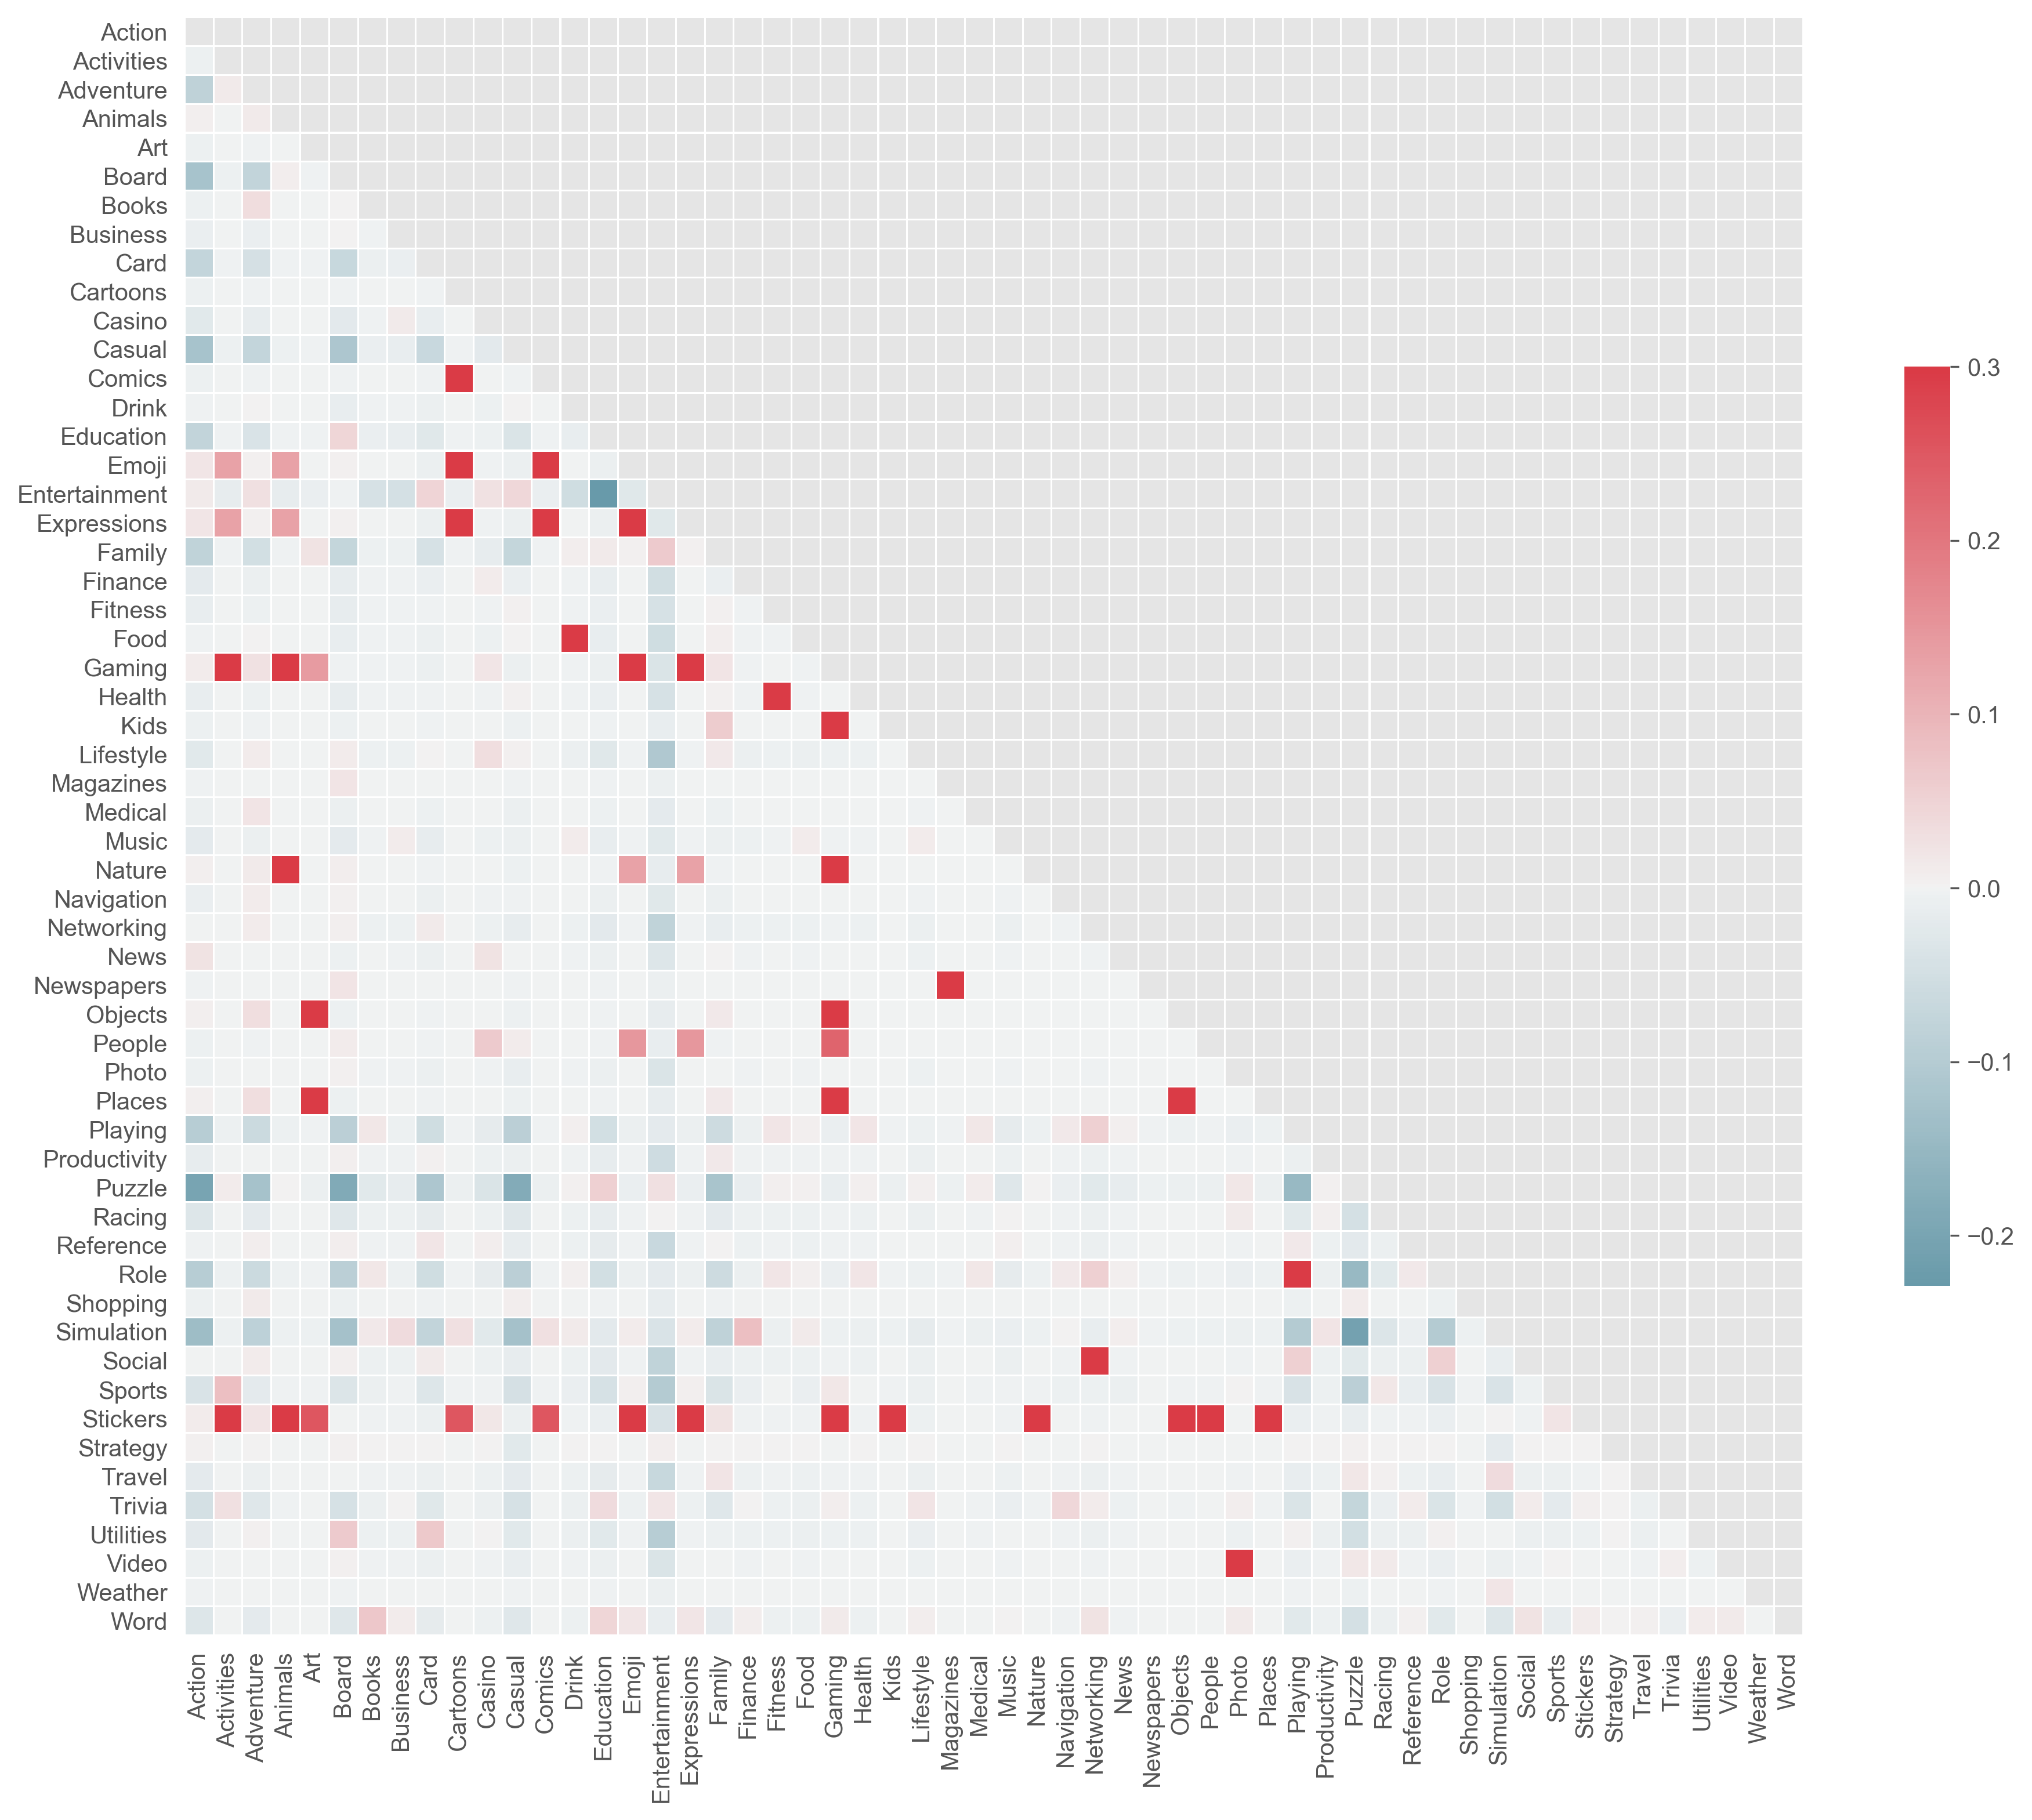

In [27]:
corr = res.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 14))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

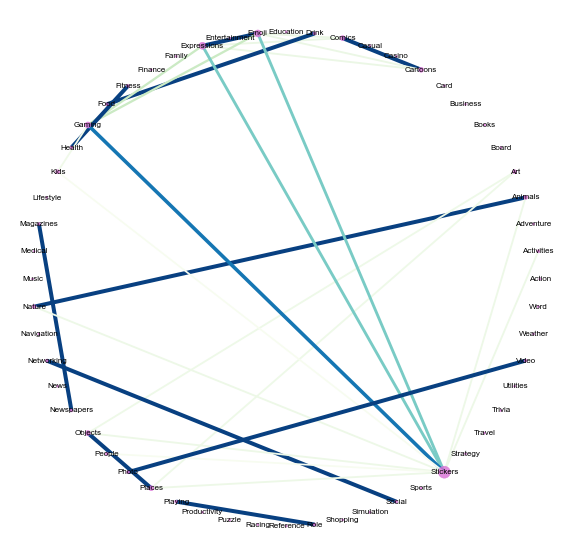

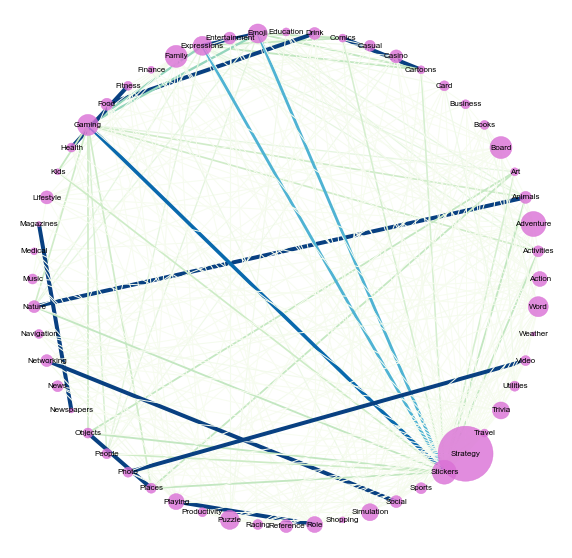

In [29]:
import networkx as nx

stocks = corr.index.values
cor_matrix = np.asmatrix(corr)
G = nx.from_numpy_matrix(cor_matrix)
G = nx.relabel_nodes(G,lambda x: stocks[x])
G.edges(data=True)

def create_corr_network(G, corr_direction, min_correlation):
    H = G.copy()
    for stock1, stock2, weight in G.edges(data=True):
        if corr_direction == "positive":
            if weight["weight"] <0 or weight["weight"] < min_correlation:
                H.remove_edge(stock1, stock2)
        else:
            if weight["weight"] >=0 or weight["weight"] > min_correlation:
                H.remove_edge(stock1, stock2)
                
    edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
    weights = tuple([(1+abs(x))**2 for x in weights])
    d = nx.degree(H)
    nodelist, node_sizes = zip(*d)
    positions=nx.circular_layout(H)
    
    plt.figure(figsize=(10,10), dpi=72)

    nx.draw_networkx_nodes(H,positions,node_color='#DA70D6',nodelist=nodelist,
                           node_size=tuple([x**2 for x in node_sizes]),alpha=0.8)
    
    nx.draw_networkx_labels(H, positions, font_size=8, 
                            font_family='sans-serif')
    
    if corr_direction == "positive": edge_colour = plt.cm.GnBu 
    else: edge_colour = plt.cm.PuRd
        
    nx.draw_networkx_edges(H, positions, style='solid',
                          width=weights, edge_color = weights, edge_cmap = edge_colour,
                          edge_vmin = min(weights), edge_vmax=max(weights))
    plt.axis('off')
    plt.show() 
    
create_corr_network(G, 'positive', 0.3)
create_corr_network(G, 'positive', -0.3)